In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

from sklearn.metrics import roc_auc_score

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmedakram1","key":"55e8f2815d9380d549a31b1e2c714508"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c tabular-playground-series-nov-2021

tabular-playground-series-nov-2021.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip tabular-playground-series-nov-2021.zip -d tps_nov_2021

Archive:  tabular-playground-series-nov-2021.zip
replace tps_nov_2021/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tps_nov_2021/sample_submission.csv  
replace tps_nov_2021/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tps_nov_2021/test.csv   y
y

replace tps_nov_2021/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: tps_nov_2021/train.csv  y



In [7]:
id_column = "id"
train_data = pd.read_csv("/content/tps_nov_2021/train.csv", index_col=id_column)
train_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [8]:
test_data = pd.read_csv("/content/tps_nov_2021/test.csv", index_col=id_column)
test_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
600000,0.003229,4.838660,585.529,2.282910,0.713180,3.907830,0.480696,1.482270,4.891810,0.056351,...,0.112910,1.073550,0.122149,0.086330,0.036010,0.010619,0.290343,1.898200,0.131533,0.012047
600001,0.008602,0.505536,-100.099,3.012670,0.027199,1.194610,5.036620,2.517440,4.553890,0.063876,...,-0.020214,2.622340,0.123307,0.033063,0.123059,0.005771,-0.392923,3.689640,0.047418,0.120015
600002,1.461000,2.437260,-112.964,3.541230,0.752338,4.338310,1.648080,4.699910,1.950250,0.005303,...,-0.011036,2.030180,-0.000426,0.084091,0.123605,0.499554,4.054650,3.330670,0.108843,0.064687
600003,0.140556,3.085610,179.451,0.573945,0.057342,2.216790,1.623480,0.526174,1.542540,-0.026160,...,0.050117,0.221613,0.045298,0.129966,0.004015,0.018279,2.696580,-0.533491,0.052524,0.011058
600004,0.128876,5.199760,107.466,-0.497149,0.080220,0.458121,0.629839,5.240460,-0.232279,0.030006,...,0.058860,2.660430,0.135425,0.036481,0.093912,0.056315,1.110710,3.584470,0.145319,-0.050393


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 599999
Columns: 101 entries, f0 to target
dtypes: float64(100), int64(1)
memory usage: 466.9 MB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540000 entries, 600000 to 1139999
Data columns (total 100 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      540000 non-null  float64
 1   f1      540000 non-null  float64
 2   f2      540000 non-null  float64
 3   f3      540000 non-null  float64
 4   f4      540000 non-null  float64
 5   f5      540000 non-null  float64
 6   f6      540000 non-null  float64
 7   f7      540000 non-null  float64
 8   f8      540000 non-null  float64
 9   f9      540000 non-null  float64
 10  f10     540000 non-null  float64
 11  f11     540000 non-null  float64
 12  f12     540000 non-null  float64
 13  f13     540000 non-null  float64
 14  f14     540000 non-null  float64
 15  f15     540000 non-null  float64
 16  f16     540000 non-null  float64
 17  f17     540000 non-null  float64
 18  f18     540000 non-null  float64
 19  f19     540000 non-null  float64
 20  f20     540000 non-null  float64
 21  f21     

In [11]:
from re import I
submission = pd.read_csv("/content/tps_nov_2021/sample_submission.csv", index_col=id_column)
submission.head()

,target
id,
600000,0.5
600001,0.5
600002,0.5
600003,0.5
600004,0.5


In [12]:
label = 'target'
features = [col for col in train_data.columns if 'f' in col]

cont_features = []
disc_features = []

for col in features:
    if train_data[col].dtype=='float64':
        cont_features.append(col)
    else:
        disc_features.append(col)

train_data[cont_features] = train_data[cont_features].astype('float32')
train_data[disc_features] = train_data[disc_features].astype('uint8')
train_data[cont_features] = train_data[cont_features].astype('float32')
train_data[disc_features] = train_data[disc_features].astype('uint8')

In [13]:
import gc

gc.collect()

0

In [14]:
train_data[:5]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.804001,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.533600,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.546005,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209,0
3,-0.014077,0.24600,779.966980,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,-0.003259,3.71542,156.128006,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 599999
Columns: 101 entries, f0 to target
dtypes: float32(100), int64(1)
memory usage: 238.0 MB


In [16]:
train_data['target'].value_counts()

,count
target,
1,303606
0,296394


In [17]:
X_train, y_train = train_data.drop(['target'], axis = 1), train_data['target']

In [18]:
class LogisticRegression(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LogisticRegression,self).__init__()
        self.f1 = nn.Linear(input_dim, 1000)
        self.f2 = nn.Linear(1000, output_dim)

    def forward(self,x):
        x = self.f1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p = 0.2)
        x = self.f2(x)
        return  F.sigmoid(x)

In [19]:
batch_size = 500
batch_no = len(X_train) // batch_size

In [20]:
X_train.shape

(600000, 100)

In [21]:
def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for i in range(len(X)//batch_size):
        if i + batch_size >= len(X):
            continue
        ind = perm[i*batch_size : (i+1)*batch_size]
        yield (X[ind], y[ind])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
pip install --upgrade sympy

Epoch 0: loss 0.6607092391947905, ROC 0.5876287680213289
Epoch 50: loss 0.5700398268302281, ROC 0.7483935259281623
Epoch 100: loss 0.5670909953614076, ROC 0.748601731162668


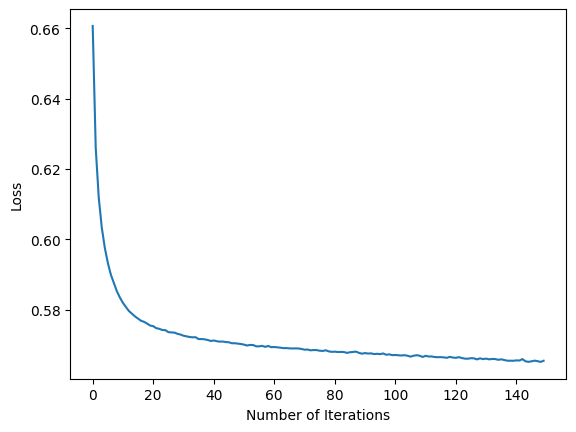

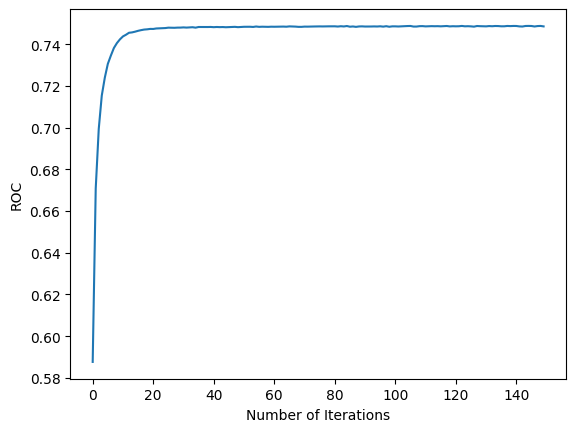

In [25]:
input_dim = 100
output_dim = 2
learning_rate = 0.0001
model = LogisticRegression(input_dim,output_dim).to(device)
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
roc_list = []
iteration_number = 150

for iteration in range(iteration_number):
    batch_loss = 0
    batch_roc = 0
    size = 0

    for (x, y) in generate_batches(X_train, y_train, batch_size):
        inputs = Variable(torch.from_numpy(x)).float().to(device)
        labels = Variable(torch.from_numpy(y)).long().to(device)

        optimizer.zero_grad()
        results = model(inputs)
        loss = error(results, labels)

        batch_loss += loss.item()

        loss.backward()
        optimizer.step()

        batch_roc += roc_auc_score(labels.detach().cpu().numpy(), results[:, 1].detach().cpu().numpy())
        size += 1

    loss_list.append(batch_loss/batch_no)
    roc_list.append(batch_roc/size)

    if (iteration % 50 == 0):
        print('Epoch {}: loss {}, ROC {}'.format(iteration, batch_loss / batch_no, batch_roc / size))

plt.plot(range(iteration_number), loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()
plt.plot(range(iteration_number), roc_list)
plt.xlabel("Number of Iterations")
plt.ylabel("ROC")
plt.show()

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If test_data is already a tensor, just detach it and move to device
test_data = test_data.detach().float().to(device)  # detach removes grad tracking

# Set model to evaluation mode
model.eval()

# Inference without tracking gradients
with torch.no_grad():
    predictions = model(test_data)


In [31]:
submission['target'] = predictions[:, 1].detach().cpu().numpy()
submission[:5]

,target
id,
600000,1.000000
600001,1.000000
600002,1.000000
600003,0.000049
600004,0.999998
